In [311]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import random
from random import sample

In [313]:
#import_data
job_sequence = np.array(pd.read_excel("jobshop_final2.xlsx", "sequence"))
job_amount = job_sequence.shape[0]
machine_amount = job_sequence.shape[1]
processing_time = np.array(pd.read_excel("jobshop_final2.xlsx", "processing time"))
time_table = np.zeros((machine_amount, job_amount))#record processing time by x-machine, y-job
print(machine_amount, job_amount)
for i in range(job_amount) :
    for j in range(machine_amount) :
        time_table[job_sequence[i][j]][i] = processing_time[i][j]

print("job_sequence")
print(job_sequence)
print("proccessing time")
print(processing_time)
print("time_table")
print(time_table)

15 15
job_sequence
[[ 6 12  4  7  3  2 10 11  8 14  9 13  5  0  1]
 [ 4  5  7 14 13  8 11  9  6 10  0  3 12  1  2]
 [ 1  8  9 12  6 11 13  5  0  2  7 10  4  3 14]
 [ 5  2  9  6 10  0 13  4  7 14 11  8 12  1  3]
 [ 7  8  6 10  4  9  2 14 12  5  1 13 11  0  3]
 [ 5  3 12 13 11  4 14  7  2  1 10  0  9  6  8]
 [12  3  7  8 14  6  1 11  4  5  2 10  0 13  9]
 [11  5  0  7 12 13 14  1  2  8  4  3  9  6 10]
 [10 11  6 14  0  1  2  5 12  4  8  7  9 13  3]
 [ 6 11  9  2  8  0 13  3 10  7  1 12 14  4  5]
 [ 4  7 13  0  5 12  6  8 14 10  3  1 11  9  2]
 [ 2 14  0 12  6 10  7  5  8  9 13  1  3 11  4]
 [ 5  8 10  2  3  6  9  0 13  4  1 11 12  7 14]
 [ 8 14  4 13  5  6  9  1 12  7 11 10  3  2  0]
 [10  8 12  6  4  1 13 14 11  0  7  3  2  9  5]]
proccessing time
[[94 66 10 53 26 15 65 82 10 27 93 92 96 70 83]
 [74 31 88 51 57 78  8  7 91 79 18 51 18 99 33]
 [ 4 82 40 86 50 54 21  6 54 68 82 20 39 35 68]
 [73 23 30 30 53 94 58 93 32 91 30 56 27 92  9]
 [78 23 21 60 36 29 95 99 79 76 93 43 52 42 96]
 [2

In [316]:
#sub_funciton
def find_array_index(list_, value) :
    for index in range(len(list_)) :
        if list_[index] == value :
            return index

def find_next_machine(selected_node, job_sequence) :#find next node of same job
    index = find_array_index(job_sequence[selected_node[1]], selected_node[0]) + 1
    machine = job_sequence[selected_node[1]][index]
    return (machine, selected_node[1])

def find_previous_machine(selected_node, job_sequence) : #find previous node of same job
    index = find_array_index(job_sequence[selected_node[1]], selected_node[0]) - 1
    machine = job_sequence[selected_node[1]][index]
    return (machine, selected_node[1])

def update_earliest_finish_time_table(selected_node, time_table, job_sequence, earliest_finish_time_table, selected_set, job_amount) :
    #check same job time 
    if find_array_index(job_sequence[selected_node[1]], selected_node[0]) != 0 :
        previous_node = find_previous_machine(selected_node, job_sequence)
        earliest_finish_time = earliest_finish_time_table[previous_node[0]][previous_node[1]] + time_table[selected_node[0]][selected_node[1]]
    else :
        earliest_finish_time = time_table[selected_node[0]][selected_node[1]]
     #check same machine time
    for job in range(job_amount) :
        if (selected_node[0], job) in selected_set :
            if earliest_finish_time_table[selected_node[0]][job] + time_table[selected_node[0]][selected_node[1]] > earliest_finish_time :
                earliest_finish_time = earliest_finish_time_table[selected_node[0]][job] + time_table[selected_node[0]][selected_node[1]]
    earliest_finish_time_table[selected_node[0]][selected_node[1]] = earliest_finish_time
    
def min_candidate_node(candidate_set, time_table, job_sequence, earliest_finish_time_table, selected_set, job_amount) : 
    time = float("inf")
    machine = 0
    for node in candidate_set :
        #check same job time
        if find_array_index(job_sequence[node[1]], node[0]) != 0 :
            previous_node = find_previous_machine(node, job_sequence)
            earliest_finish_time = earliest_finish_time_table[previous_node[0]][previous_node[1]] + time_table[node[0]][node[1]]
        else :
            earliest_finish_time = time_table[node[0]][node[1]]
        #check same machine time
        for job in range(job_amount) :
            if (node[0], job) in selected_set :
                if earliest_finish_time_table[node[0]][job] + time_table[node[0]][node[1]] > earliest_finish_time :
                    earliest_finish_time = earliest_finish_time_table[node[0]][job] + time_table[node[0]][node[1]]
        if earliest_finish_time < time :
            time = earliest_finish_time
            machine = node[0]
    return machine

def find_sub_cadidate_set(i, candidate_set) :
    sub_cadidate_set = []
    for node in candidate_set :
        if node[0] == i :
             sub_cadidate_set.append(node)
    return sub_cadidate_set

def update_machine_sequence(machine_sequence, selected_node) :
    for sequence in range(job_amount) :
        if machine_sequence[selected_node[0]][sequence] == -1 :#still not ocuupy
            machine_sequence[selected_node[0]][sequence] = selected_node[1]
            break

def update_ancient_map(selected_node, selected_set, ancient_map) :
    for job in range(job_amount) :
        if (selected_node[0], job) in selected_set == False :
            ancient_map[selected_node[0]][job] = selected_node      

def find_Cmax_of_the_node(node, machine_sequence, ancient_map, job_sequence) :
    forward = 0
    backward = 0
    #find backward
    #culminative time of previous node same job
    if find_array_index(job_sequence[node[1]], node[0]) != 0 :#not a first procss in same job   
        previous_node = find_previous_machine(node, job_sequence)
        culminative_time_same_job = earliest_finish_time_table[previous_node[0]][previous_node[1]]
    else :
        culminative_time_same_job = 0
    #culminative time of previous node same machine
    if ancient_map[node[0]][node[1]] != 0 :#not a first procss in same job 
        previous_node = ancient_map[node[0]][node[1]]
        culminative_time_same_machine = earliest_finish_time_table[previous_node[0]][previous_node[1]]
    else :
        culminative_time_same_machine = 0
    backward = max(culminative_time_same_job, culminative_time_same_machine)
    #find forward
    for job in range(job_amount) :
        if (node[0], job) in selected_set == False :#only can connect with node without selected
            if job == node[1] :#node itself
                if sum(processing_time[processing_time[job].index(node[0]):]) > forward :
                    forward = sum(processing_time[job][processing_time[job].index(node[0]):])
            else :
                if time_table[node[0]][node[1]] + sum(processing_time[job][processing_time[job].index(node[0]):]) > forward :
                    forward = time_table[node[0]][node[1]] + sum(processing_time[processing_time[job].index(node[0]):])
    return forward + backward                      
    
                
def choose_node(sub_cadidate_set, machine_sequence, ancient_map, job_sequence, Cmax, selected_set, job_amount):
    smallist_Camx = float("inf")
    selected_node = (-1, -1)
    for node in sub_cadidate_set :
        node_Cmax = find_Cmax_of_the_node(node, machine_sequence, ancient_map, job_sequence)
        if node_Cmax < smallist_Camx :
            smallist_Camx = node_Cmax
            selected_node = node
    update_earliest_finish_time_table(selected_node, time_table, job_sequence, earliest_finish_time_table, selected_set, job_amount)
    selected_set.append(selected_node)
    if smallist_Camx > Cmax :
        Cmax = smallist_Camx
    update_machine_sequence(machine_sequence, selected_node)
    update_ancient_map(selected_node, selected_set, ancient_map)
    return Cmax, selected_node    

def adjust_selected_candidate_sets(candidate_set, selected_set, selected_node, job_sequence) :
    selected_set.append(selected_node)
    del candidate_set[candidate_set.index(selected_node)]
    #add next process of same job
    if selected_node[0] != job_sequence[selected_node[1]][-1] :#not lsat process of job
        candidate_set.append(find_next_machine(selected_node, job_sequence))
        
def find_max(table) :
    maxmum = 0
    for i in range(len(table)) :
        if max(table[i]) > maxmum :
            maxmum = max(table[i])
    return int(maxmum)
    
def jobshop_graph(finish_time_table, start_time_table, machine_amount, job_amount) :
    color = ['aliceblue', 'antiquewhite', 'aqua', 'aquamarine', 'azure', 'beige', 'bisque', 'black', 'blanchedalmond', 'blue', 'blueviolet', 'brown', 'burlywood', 'cadetblue', 'chartreuse', 'chocolate', 'coral', 'cornflowerblue', 'cornsilk']
    plt.figure(figsize=(60,30))
    for machine in range(machine_amount) :
        for job in range(job_amount) :
            start_time = int(start_time_table[machine][job])
            finish_time = int(finish_time_table[machine][job])
            plt.plot([start_time, finish_time], [machine, machine],  linewidth = '20', color = color[job])
            plt.xticks(range(0, find_max(finish_time_table)+1, 1))
            plt.yticks([0,1,2,3])
            plt.ylabel("machine", fontsize = 16)
            plt.xlabel("timing", fontsize = 16)
    plt.show()

[[1102.  909.  690.  379. 1172.  959.  781.  219.  322.  305.  192.   92.
   574. 1046.  660.]
 [1372. 1043.    0. 1187.  950.  812.  446.  750.  359.  681. 1279. 1142.
   845.  512.  333.]
 [ 304. 1142.  757.   73.  541.  636.  714.  825.  446.  204. 1413.    0.
   326.  965.  882.]
 [ 278.  927. 1148. 1365. 1269.  102.   18.  978. 1254.  426. 1058. 1187.
   346.  882.  795.]
 [ 215.    0. 1007.  604.  439.  376.  519.  956.  709.  935.   74. 1312.
   765.  164.  296.]
 [1006.  219.  684.    0.  874.   73.  611.  167.  528.  950.  250.  765.
   102.  341. 1126.]
 [   0.  737.  453.  211.  241. 1188.  296. 1202.  115.   94.  587.  536.
   503.  364.  262.]
 [ 225.  327.  827.  795.    0.  472.   93.  278.  909.  593.  164.  681.
  1071.  765.  783.]
 [ 722.  644.   28. 1056.  110. 1202.  133.  894.  781.  264.  732.  866.
   167.    0.  142.]
 [ 821.  730.  126.   96.  512. 1126.  974. 1188. 1040.  174. 1378.  914.
   541.  453. 1106.]
 [ 439.  830.  987.  326.  379.  909.  757. 1259. 

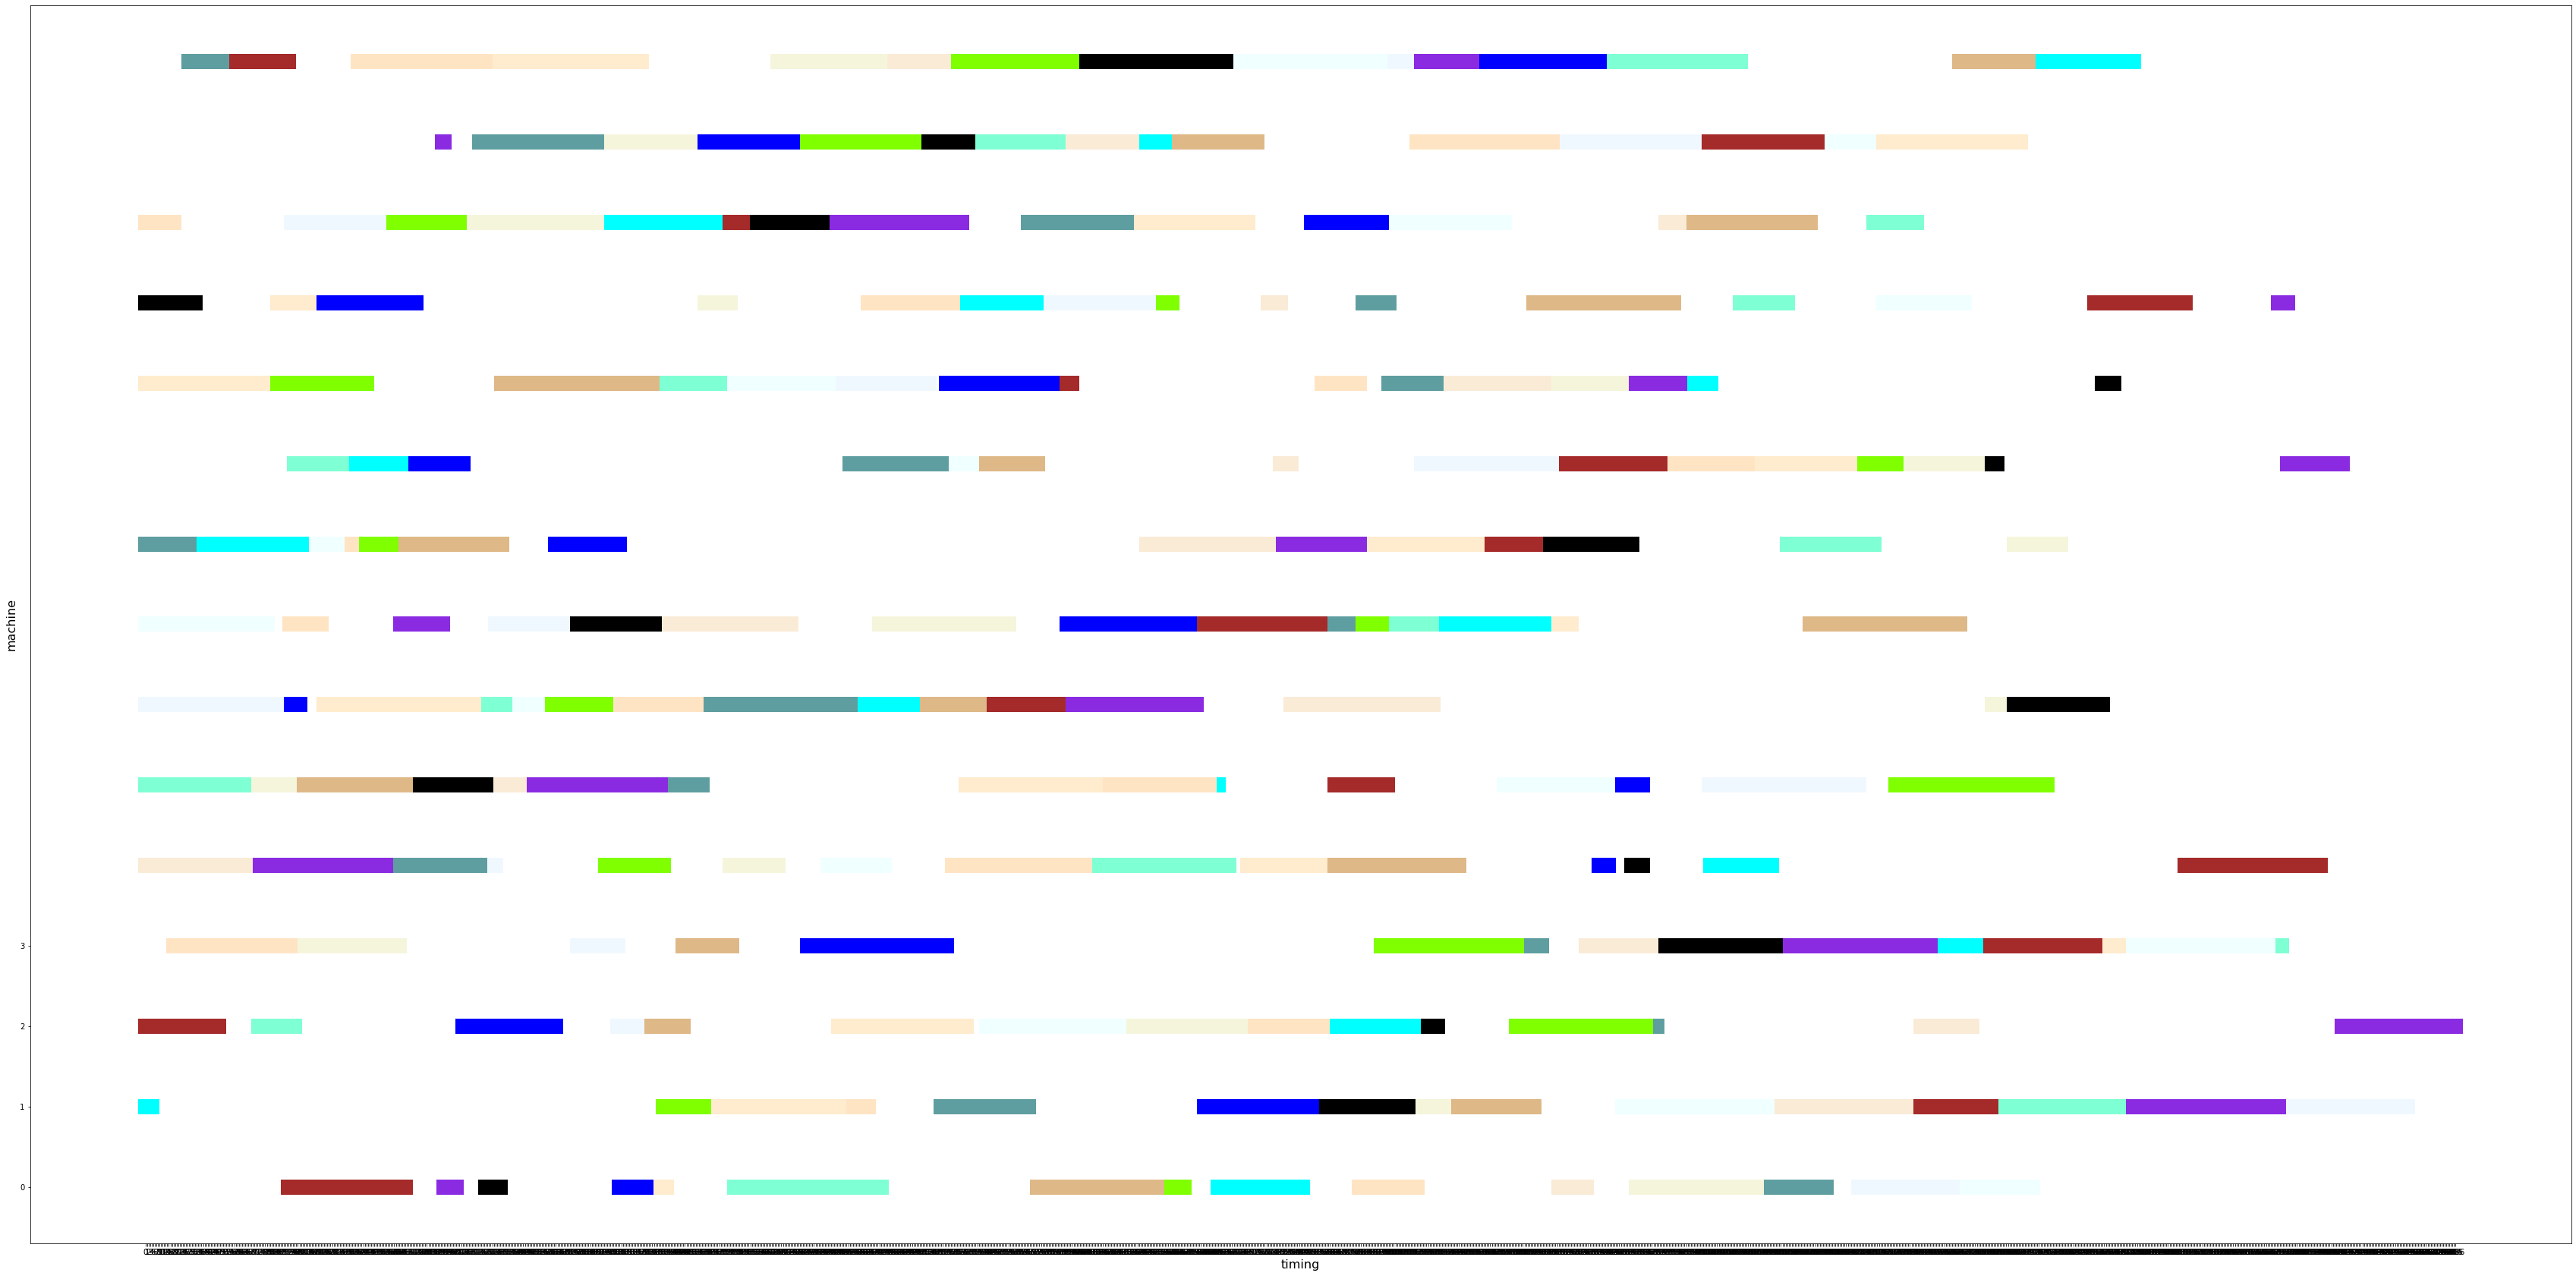

In [317]:
#traditional way
#parameters
machine_sequence = np.full((machine_amount, job_amount), -1)
candidate_set = [] #(machine, job)
selected_set = []
Cmax = 0
ancient_map = [[0 for i in range(job_amount)]for j in range(machine_amount)]#record sequence of same machine
earliest_finish_time_table = np.zeros((machine_amount, job_amount))#record 
#initialize
for i in range(job_amount) : #initial candidate set
    candidate_set.append((job_sequence[i][0], i))
for i in range(job_amount) : #initial current Cmax
    if sum(processing_time[i][:]) > Cmax :
            Cmax = sum(processing_time[i][:])
#main_function
for iteration in range(machine_amount*job_amount) :
    i = min_candidate_node(candidate_set, time_table, job_sequence, earliest_finish_time_table, selected_set, job_amount)
    sub_cadidate_set = find_sub_cadidate_set(i, candidate_set)
    Cmax, selected_node = choose_node(sub_cadidate_set, machine_sequence, ancient_map, job_sequence, Cmax, selected_set, job_amount)
    adjust_selected_candidate_sets(candidate_set, selected_set, selected_node, job_sequence)

start_time_table = earliest_finish_time_table - time_table
print(start_time_table)
print(earliest_finish_time_table)
jobshop_graph(earliest_finish_time_table, start_time_table, machine_amount, job_amount)

In [299]:
#蒙地卡羅search
#sub_finction
def find_array_index(list_, value) :
    for index in range(len(list_)) :
        if list_[index] == value :
            return index
        
def find_previous_machine(selected_node, job_sequence) : #find previous node of same job
    index = find_array_index(job_sequence[selected_node[1]], selected_node[0]) - 1
    machine = job_sequence[selected_node[1]][index]
    return (machine, selected_node[1])

def creat_all_node(machine_amount, job_amount) :
    all_node = []
    for machine in range(machine_amount) :
        for job in range(job_amount) :
            all_node.append((machine, job))
    return all_job

def check_sequence(sequence, node) :
    for i in range(len(sequence)) :
        if sequence[i][0] == node[0] and sequence[i][1] == node[1] :
            return True
    return False

def rule_random(selected_set, job_sequence, machine_amount, job_amount) :
    sequence = copy.deepcopy(selected_set)
    while len(sequence) < machine_amount*job_amount :
        random_job = random.randint(0, job_amount-1) 
        for i in range(machine_amount) :
            if check_sequence(sequence, (job_sequence[random_job][i], random_job)) == False:
                sequence.append((job_sequence[random_job][i], random_job))   
                break
    return sequence
    
def count_mean_Cmax(selected_set, remain_set, serach_times,  machine_amount, job_amount, time_table) :
    accu_machine_time = np.zeros((1, machine_amount))
    finish__table = np.zeros((machine_amount, job_amount))
    mean_Cmax = 0
    for iteration in range(serach_times) :
        sequence = rule_random(selected_set)
        for node in sequence :
            if find_array_index(job_sequence[node[1]], node[0]) != 0 :
                previous_node = find_previous_machine(node, job_sequence)
                time = finish__table[previous_node[0]][previous_node[1]]
            else :
                time = 0
            start_time = max(accu_machine_time[node[0]], time)
            finish__table[mode[0]][node[1]] = start_time + time_table[node[0]][node[1]]
            accu_machine_time[node[0]] = finish__table[mode[0]][node[1]]
        mean_Cmax =(mean_Cmax*iteration + max(accu_machine_time)) / (iteration + 1)
    return mean_Cmax

def choose_node(selected_set, remain_set, conadidate_set, serach_times, machine_amount, job_amount) :
    mean_Cmax = 0
    samll_Cmax = float("inf")
    selectd_node = (-1, -1)
    for node in conadidate_set :
        temp_remain_set = copy.deepcopy(remain_set)
        temp_selected_set = selected_set + node
        mean_Cmax = count_mean_Cmax(temp_selected_set, temp_remain_set.remove(node), search_times, machine_amount, job_amount, time_table)
        if maen_Cmax < small_Cmax :
            small_Cmax = mean_Cmax
            selected_node = node
    return selected_node

def update_finish_time_table(node, finish_time_table, job_sequence, time_table) :
    if find_array_index(job_sequence[node[1]], node[0]) != 0 : 
        previous_node = find_previous_machine(node, job_sequence)
        previous_time_same_job = finish_time_table[previous_node[0]][previous_node[1]]
    else :
        previous_time_same_job = 0
    previous_time_same_machine = max(finish_time_table[node[0]])
    finish_time_table[node[0]][node[1]] = max(previous_time_same_job, previous_time_same_machine)

def adjust_selected_candidate_sets(candidate_set, selected_set, selected_node, job_sequence) :
    selected_set.append(selected_node)
    del candidate_set[candidate_set.index(selected_node)]
    #add next process of same job
    if selected_node[0] != job_sequence[selected_node[1]][-1] :#not lsat process of job
        candidate_set.append(find_next_machine(selected_node, job_sequence))

def jobshop_graph(finish_time_table, start_time_table, machine_amount, job_amount) :
    color = ['aliceblue', 'antiquewhite', 'aqua', 'aquamarine', 'azure', 'beige', 'bisque', 'black', 'blanchedalmond', 'blue', 'blueviolet', 'brown', 'burlywood', 'cadetblue', 'chartreuse', 'chocolate', 'coral', 'cornflowerblue', 'cornsilk']
    plt.figure(figsize=(10,5))
    for machine in range(machine_amount) :
        for job in range(job_amount) :
            start_time = int(start_time_table[machine][job])
            finish_time = int(finish_time_table[machine][job])
            plt.plot([start_time, finish_time], [machine, machine],  linewidth = '20', color = color[job])
            plt.xticks(range(0, find_max(finish_time_table)+1, 1))
            plt.yticks([0,1,2,3])
            plt.ylabel("machine", fontsize = 16)
            plt.xlabel("timing", fontsize = 16) 
    plt.show()

In [300]:
#parameter
remain_set = creat_all_node(machine_amount, job_amount)
finish_time_table = np.zeros((machine_amount, job_amount))# fill it all at once after whole sequence determinded
selected_node = []#have sequence concept 
candidate_set = []
search_times = 100
#initialize
for i in range(job_amount) : #initial candidate set
    candidate_set.append((job_sequence[i][0], i))

#main function
for iteration in range(machine_amount*job_amount) :
    node = choose_node()
    update_finish_time_table(finiah_time_table, node)
    adjust_selected_candidate_sets()

start_time_table = finish_time_table - time_table
jobshop_graph(earliest_finish_time_table, start_time_table, machine_amount, job_amount)

NameError: name 'all_job' is not defined

True